In [ ]:
!nvidia-smi

Thu Jun  9 22:23:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.get_device_name(0))

1.11.0+cu113
Tesla T4


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import time
import os
import torch.backends.cudnn as cudnn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
start_time = time.time()

### Data
#### Augmentation

In [ ]:
high_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(0.1),
    # transforms.ColorJitter(contrast=0.1, saturation=0.1, hue=0.1),
    # transforms.RandomAffine(30, translate=(0.2,0.2), scale=(0.8,1.6), shear=20),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467),
                          std=(0.2471, 0.2436, 0.2616))
])

low_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467),
                          std=(0.2471, 0.2436, 0.2616))
])

transform_train = transforms.RandomChoice([high_transform_train,low_transform_train],p=[1,0])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4824, 0.4467),
                          std=(0.2471, 0.2436, 0.2616))
])

#### Data loader

In [ ]:
image_size = (3,32,32)
train_dataset = datasets.CIFAR10(root='/content/pytorch/data/cifar10/',
                                 train=True,
                                 transform=transform_train,
                                 download=True)


test_dataset = datasets.CIFAR10(root='/content/pytorch/data/cifar10/',
                                train=False,
                                transform=transform_test)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)


Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels_map= {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck',
}

def imshow():
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


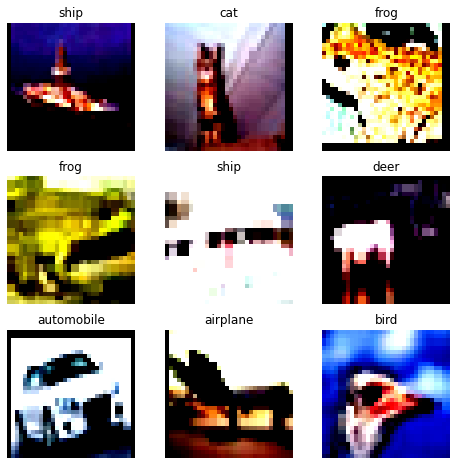

In [ ]:
imshow()

### Design Model

In [ ]:
class Vgg(nn.Module):
    def __init__(self, num_classes=10):
        super(Vgg, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        # x.size()=[batch_size, channel, width, height] 
        #          [128, 512, 2, 2] 
        # flatten 결과 => [128, 512x2x2] 
        x = self.classifier(x)
        return x


In [ ]:
summary(Vgg().cuda(), image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [ ]:
# 참조: https://deep-learning-study.tistory.com/534 
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        # self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        # x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
model = ResNet(BasicBlock, [1,2,1]).cuda()
summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12            [-1, 128, 4, 4]          73,728
      BatchNorm2d-13            [-1, 128, 4, 4]             256
             ReLU-14            [-1, 12

In [ ]:
class OneShortcut(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features_2 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.GELU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            
        )
        self.shortcut = nn.Sequential(
            # nn.Conv2d(128, 256, kernel_size=1,stride=2, bias=False),
            # nn.BatchNorm2d(256)
        )

        self.merge = nn.Sequential(
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.features_3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3 , padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.classifier = nn.Linear(128, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features_1(x)
        x = self.features_2(x) + self.shortcut(x)
        x = self.merge(x)
        x = self.features_3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
summary(OneShortcut().cuda(), image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              GELU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             GELU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             GELU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [ ]:
def train(epoch, writer:SummaryWriter = None):
    model.train()
    train_loss = 0
    total = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        # torch.max() : (maximum value, index of maximum value) return. 
        # 1 :  row마다 max계산 (즉, row는 10개의 class를 의미) 
        # 0 : column마다 max 계산 
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
        if batch_idx % 10 == 0:        
            print('Epoch: {} | Batch_idx: {} |  Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
                  .format(epoch, batch_idx, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
            if writer:
                writer.add_scalar('Loss/train', train_loss/(batch_idx+1), epoch*40 + batch_idx//10)
                writer.add_scalar('Accuracy/train', 100.*correct/total, epoch*40 + batch_idx//10)

In [ ]:
def test(epoch, writer:SummaryWriter = None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = Variable(data.cuda()), Variable(target.cuda())
        else:
            data, target = Variable(data), Variable(target)

        outputs = model(data)
        loss = criterion(outputs, target)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()
    print('# TEST : Loss: ({:.4f}) | Acc: ({:.2f}%) ({}/{})'
      .format(test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    if writer:
        writer.add_scalar('Loss/test', test_loss/(batch_idx+1), epoch)
        writer.add_scalar('Accuracy/test', 100.*correct/total, epoch)


### train & test

In [ ]:
learning_rate = 0.01

# model = Vgg()
# model = ResNet(BasicBlock, [1,2,1])
model = OneShortcut()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-2)
criterion = nn.CrossEntropyLoss(label_smoothing=0.2).cuda()

if torch.cuda.device_count() > 0:
    print("USE", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    cudnn.benchmark = True
else:
    print("USE ONLY CPU!")

if torch.cuda.is_available():
    model.cuda()

USE 1 GPUs!


In [ ]:
def run(writer=None):
    for epoch in range(0, 50):
        for param_group in optimizer.param_groups:
            param_group['learning_rate'] = learning_rate / 2**(epoch/5)

        train(epoch, writer)
        test(epoch, writer)

In [ ]:
write = True
if write:
    with SummaryWriter() as writer:
        run(writer)
else:
    run()

Epoch: 0 | Batch_idx: 0 |  Loss: (2.3075) | Acc: (7.81%) (10/128)
Epoch: 0 | Batch_idx: 10 |  Loss: (2.2523) | Acc: (14.77%) (208/1408)
Epoch: 0 | Batch_idx: 20 |  Loss: (2.2061) | Acc: (17.60%) (473/2688)
Epoch: 0 | Batch_idx: 30 |  Loss: (2.1756) | Acc: (19.05%) (756/3968)
Epoch: 0 | Batch_idx: 40 |  Loss: (2.1568) | Acc: (20.12%) (1056/5248)
Epoch: 0 | Batch_idx: 50 |  Loss: (2.1435) | Acc: (21.12%) (1379/6528)
Epoch: 0 | Batch_idx: 60 |  Loss: (2.1284) | Acc: (21.61%) (1687/7808)
Epoch: 0 | Batch_idx: 70 |  Loss: (2.1169) | Acc: (22.55%) (2049/9088)
Epoch: 0 | Batch_idx: 80 |  Loss: (2.1052) | Acc: (23.45%) (2431/10368)
Epoch: 0 | Batch_idx: 90 |  Loss: (2.0956) | Acc: (23.94%) (2788/11648)
Epoch: 0 | Batch_idx: 100 |  Loss: (2.0862) | Acc: (24.83%) (3210/12928)
Epoch: 0 | Batch_idx: 110 |  Loss: (2.0732) | Acc: (25.72%) (3654/14208)
Epoch: 0 | Batch_idx: 120 |  Loss: (2.0590) | Acc: (26.60%) (4120/15488)
Epoch: 0 | Batch_idx: 130 |  Loss: (2.0504) | Acc: (27.11%) (4546/16768)
Epoc

In [ ]:
now = time.gmtime(time.time() - start_time)
print('{} hours {} mins {} secs for training'.format(now.tm_hour, now.tm_min, now.tm_sec))

0 hours 20 mins 24 secs for training


In [ ]:
!zip -ur /content/loss_accuracy_graph.zip /content/runs

updating: content/runs/ (stored 0%)
  adding: content/runs/Jun09_22-23-31_2c1cfd24645c/ (stored 0%)
  adding: content/runs/Jun09_22-23-31_2c1cfd24645c/events.out.tfevents.1654813416.2c1cfd24645c.1243.0 (deflated 68%)


In [ ]:
from google.colab import files
files.download("/content/loss_accuracy_graph.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>